# Basal Mass Balance

For the portion of the ice base, which is at the pressure melting point, the basal melt rate for enthalpy is: 
$$
M_{\rm b} = \frac{ \left( F_{\rm b}  + \left( \mathbf{q}_{\rm geo}  - \mathbf{q}  \right) \cdot \mathbf{n} \right)}{(1-\omega)L\rho}
$$

where,
  - $M_b$ is the basal melt rate [m a$^{-1}$]
  - $\omega$ is the water content along the ice-bed interface [-]
  - $L$ is latent heat of fusion [J kg$^{-1}$]
  - $\rho$ is the density of ice  [kg m$^{3}$]
  - $F_{\rm b}$ is a frictional heat source [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{q}$ is the basal enthalpy gradient [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{q}_{\rm geo}$ is the geo thermal heat flux [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{n}$ is the unit normal vector which points from the bedrock into the ice

In [1]:
import cmocean
import numpy as np 
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from thermal.constants import *
from thermal.gradient import calc_gradient
from thermal.utils import calc_conductivity
from thermal.derived_fields import calc_length

plt.rcParams['text.usetex'] = True

In [2]:
def xr_gradient(src, field): 
    # dims = ['coord_2', 'coord_1']
    
    dims = list(src.dims)
    
    # multiple spatial dimensions 
    if ('coord_2' in dims) and ('coord_1' in dims):
        # add check for if time is in dims
        dFdz, dFdx = xr.apply_ufunc(calc_gradient,
                                    src[field], src['Z'], src['X'], 
                                    input_core_dims =[dims]*3, 
                                    output_core_dims=[dims]*2,
                                    output_dtypes=[src[field].dtype]*2, 
                                    dask='parallelized')
        # pack the multidimensional gradient into a single field
        grad = xr.concat((dFdz, dFdx), dim='dim')
        # relabel the dimension `dim` based on the spatial dimension
        grad = grad.assign_coords({'dim' : ['Z', 'X']})
    
    # just looking for the horizontal gradient 
    elif ('coord_1' in dims):
        dFdx = xr.apply_ufunc(np.gradient, 
                              src[field], src['X'], 
                              input_core_dims =[dims]*2, 
                              output_core_dims=[dims])
        
        # expand the gradient so it will able to be broadcast agaisnt 
        # the multidimensional gradients calculated above
        grad = dFdx.expand_dims('dim').assign_coords({'dim' : ['X']})
                            
    return grad

def calc_basal_gradient(src, field): 
    """Helper function to calculate basal gradient 
    """
    
    if 't' in src.dims: 
        grad = src.groupby('t').apply(xr_gradient, field=field)
    else: 
        # compute the gradient of the field using the wrapped ufunc
        grad = xr_gradient(src, field)
    
    # extract the values along the base: 
    # NOTE: index 0 is bed, not -1 
    grad_F_b = grad.isel(coord_2 = 0)
        
    return grad_F_b

def check_temperate(src, i): 
    """Check if ice at the i-th vertical coordinate is temperate
    """
    H_b = src.enthalpy_h.isel(coord_2=i)#.compute()
    H_f = src['phase change enthalpy'].isel(coord_2=i)#.compute()
    return (H_b >= H_f)

def calc_heat_flux(src): 
    """ Calcuate the energy flux at the ice base
    
        Whether to use temp or enth gradient depends in the state
        of the ice base (i.e. if overlying temperate ice exists). 
        See Figure 5 from Aschwanden et al. 2012 
        
        returns: (2, nx) vector 
    """
    # calculate the basal ethalpy gradient (2,nx) 
    grad_E_b = calc_basal_gradient(src, 'enthalpy_h') # [J kg-1 m-1]
    # calculate the basal temperature gradient (2,nx) 
    grad_T_b = calc_basal_gradient(src, 'temperature') # [K m-1]

    # extract the temperature along the ice/bed interface 
    T_b = src.temperature.isel(coord_2=0)

    # heat capacity conducivity along the ice base [J K-1 m-1 a-1]
    k = calc_conductivity(T_b+273.15, 910.) * spy
    # temperate ice enthalpy diffusivity
    kappa = 3.295e3     #[kg m-1 a-1]

    # compute the heat flux vector 
    q_T = -k * grad_T_b   # [J a-1 m-2]
    # compute the heat flux vector 
    q_E = -kappa * grad_E_b   # [J a-1 m-2]
    
    # find where ice-base is temperate
    temp_base  = check_temperate(src, 0)
    # will return true for gridcells which are temperate, 
    # but have no overlying temperate ice
    no_temp_layer = ~temp_base & check_temperate(sub, 1)

    # return heat flux for all areas of bed (even those frozen), 
    # valid bmb areas will need to be masked later 
    q_ice = xr.where(no_temp_layer, q_E, q_T)
    
    return q_ice

Let's load the reference glacier, and use it's steady-state resutls to figure out how significant the basal mass balance will be. 

In [3]:
src_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/result/crmpt12/gridded/Frictional_heating/crmpt12_dx_50_TT_6--9ka_MB_-0.37_OFF_Tma_-8.5_B_4.217e-04_SP_2_QP_28.zarr'
# lazy load the zarr file
src = xr.open_zarr(src_fp)
# drop the parameter dims for this purpose
src = src.squeeze()

# interpolated time 
t_interp = np.linspace(6e3, 9e3, 3_000, endpoint=False)
# downsample to annual timesteps 
src = src.interp(t=t_interp,
                 method="linear",
                 kwargs={"fill_value": "extrapolate"})

Follow Greeve and Blatter (2009), we define the ice base as: 
$$
z_{\rm b} = b(x) - z = 0
$$
where $b(x)$ is the bed elevation and $z$ is the vertical coordinate. Note $b(x)$ is constant in time.

In order to calculate the basal mass balance, we first need thr unit normal vector, 
$$
\mathbf{n} = \frac{\nabla z_{\rm b}}{|\nabla z_{\rm b}|} = \frac{1}{N_{\rm b}} 
\begin{pmatrix}
-\frac{\partial z_{\rm b}}{\partial x} \\
1
\end{pmatrix}
$$
which points from bedrock into the ice. $N_{\rm b}$ is the gradient norm, 
$$
N_{\rm b} = |\nabla z_{\rm b}| = \left(1 + \left(\frac{\partial z_{\rm b}}{\partial x}\right)^2\right)^{1/2} . 
$$

Using the reference data, let's calculate $\mathbf{n}$. 

In [4]:
# x coordinate along the bed
x_b = src.X.isel(coord_2=0)
# bed elevation is NOT time dependent 
z_b = src.Z.isel(coord_2=0, t=-1)

# number of horizontal coordinates
nx = z_b.size

# calculate bed gradient in the x direction
dbdx = np.gradient(z_b, x_b)

# caclulate gardient norm 
N_b = (1 + dbdx**2)**(1/2)

# calculate the unit normal vector 
normal = (1/N_b) * np.stack((-dbdx , np.ones(nx)), 0)

# specify the geothermal heat flux
ghf = 0.055 * spy

In [5]:
normal = xr.DataArray((1/N_b) * np.stack((-dbdx , np.ones(nx)), 0), 
                      dims=['dim', 'coord_1'], coords={'dim': ['Z', 'X']})

q_geo  = xr.DataArray(np.stack((np.zeros(nx) , ghf*np.ones(nx)), 0), 
                      dims=['dim', 'coord_1'], coords={'dim': ['Z', 'X']})

## Calculate melt rates over the $6$-$9$ka window

In [6]:
sub = src.sel(t=slice(6000,9000))

In [7]:
%%time

q_ice = calc_heat_flux(sub)

CPU times: user 1min 13s, sys: 1.86 s, total: 1min 15s
Wall time: 1min 19s


In [8]:
mask = check_temperate(sub, 0)
# get the frictional heating in J a-2 m-2
q_b = sub['friction heating'].where(lambda x: x > 0, 0)
# find mask of temperate bed
mask = check_temperate(sub, 0)
# extract basal water content [-]
omega = sub['water content'].isel(coord_2=0)
# extract temperature along the ice-base
T_b = sub.temperature.isel(coord_2=0)
# find the glacier lenght [km] for plotting purposes 
L = calc_length(sub)

bmb = -( q_b + xr.dot(q_geo*normal, dims=['dim']) - xr.dot(q_ice*normal, dims=['dim'])) / ((1-omega)*L_heat*910)
# bmb is only valid where bed is temperate 
bmb = xr.where(~mask, 0, bmb).compute()

In [9]:
y = np.arange(0,3,1)[None,:]
x = np.arange(6e3, 9e3, 30)[:, None]
surge_timesteps = (x + y).flatten()
quies_timestpes = t_interp[~np.isin(t_interp, surge_timesteps)]

In [11]:
min_sugre=float(np.abs(bmb.sel(t=surge_timesteps).min()))
min_quies=float(np.abs(bmb.sel(t=quies_timestpes).min()))

print(f'Maximum quesiecent melt rate of: {min_quies*1e3:1.3f} mm/yr')
print(f'Maximum   surging  melt rate of: {min_sugre*100:1.3f}   m/yr')

Maximum quesiecent melt rate of: 7.110 mm/yr
Maximum   surging  melt rate of: 8.733   m/yr


## Calculate melt rates over the last surge cycle 

In [12]:
src_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/result/crmpt12/gridded/Frictional_heating/crmpt12_dx_50_TT_6--9ka_MB_-0.37_OFF_Tma_-8.5_B_4.217e-04_SP_2_QP_28.zarr'
# lazy load the zarr file
src = xr.open_zarr(src_fp)
# drop the parameter dims for this purpose
src = src.squeeze()

# interpolated time 
t_interp = np.linspace(6e3, 9e3, 30_000, endpoint=False)
# downsample to annual timesteps 
src = src.interp(t=t_interp,
                 method="linear",
                 kwargs={"fill_value": "extrapolate"})

In [13]:
%%time

sub = src.sel(t=slice(8965,8977.1)).compute()

CPU times: user 2min 27s, sys: 2min 21s, total: 4min 49s
Wall time: 2min 43s


In [14]:
%%time

q_ice = calc_heat_flux(sub)

CPU times: user 2.37 s, sys: 580 ms, total: 2.95 s
Wall time: 3.3 s


In [15]:
%%time 

# get the frictional heating in J a-2 m-2
q_b = sub['friction heating'].where(lambda x: x > 0, 0)
# find mask of temperate bed
mask = check_temperate(sub, 0).compute()
# extract basal water content [-]
omega = sub['water content'].isel(coord_2=0)
# extract temperature along the ice-base
T_b = sub.temperature.isel(coord_2=0)
# find the glacier lenght [km] for plotting purposes 
L = calc_length(sub)

bmb = -( q_b + xr.dot(q_geo*normal, dims=['dim']) - xr.dot(q_ice*normal, dims=['dim'])) / ((1-omega)*L_heat*910)
# bmb is only valid where bed is temperate 
bmb = xr.where(~mask, 0, bmb).compute()

CPU times: user 19.2 ms, sys: 6.73 ms, total: 25.9 ms
Wall time: 30.5 ms


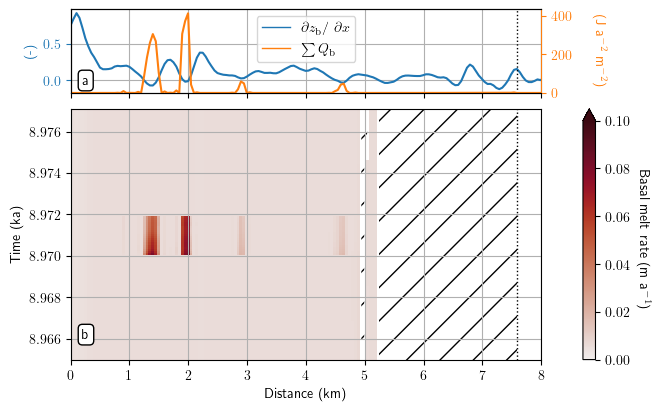

In [16]:
fig, ax = plt.subplots(2,1, height_ratios=[1, 3], sharex=True, 
                       figsize=(6.5,4),
                       constrained_layout=True)

ax[0].plot(x_b[::-1]/1e3, dbdx)

ax[0].yaxis.label.set_color('tab:blue')
ax[0].tick_params(axis='y', colors='tab:blue')
ax[0].spines['right'].set_color('tab:blue')

ax2 = ax[0].twinx()
ax2.plot(x_b[::-1]/1e3, q_b.sel(t=slice(8970,8972.0)).sum('t')/1e6, color='tab:orange')

ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.spines['right'].set_color('tab:orange')

ax2.set_ylim(0, None)

im = ax[1].pcolormesh(x_b[::-1]/1e3, bmb.t/1e3,
                      np.abs(bmb).where(mask), 
                      cmap='cmo.amp', vmax=0.1,  vmin=0.0) #norm=colors.LogNorm(vmax=0.2,  vmin=1e-2))

ax[0].axvline(L.mean(), color='k', lw=1.0, ls=':')

ax[1].plot(L, L.t/1e3, color='k', lw=1.0, ls=':')


X = sub.X.isel(coord_2=0).sortby('coord_1', ascending=False)
ax[1].contourf(x_b[::-1]/1e3, bmb.t/1e3, 
               mask.where(lambda x: (x==False) & (X/1e3 <= L)), 
               levels=1, colors='none', hatches='/')
    
ax[0].grid()
ax[1].grid()

ax[0].set_ylabel(r'(-)')
ax2.set_ylabel(r'(J a$^{-2}$ m$^{-2}$)', rotation=270, labelpad=25)
ax[1].set_ylabel('Time (ka)')
ax[1].set_xlabel('Distance (km)')

custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='tab:orange', lw=1)]

ax[0].legend(custom_lines, [r'$\partial z_{\rm b} /\ \partial x$', 
                            r'$\sum Q_{\rm b}$'])

# add annotations to srcplots
labels = ['a', 'b', 'c']
for i in range(2):             
        ax[i].text(0.025, 0.075, labels[i], 
                   ha='left', va='bottom', transform=ax[i].transAxes, 
                   bbox=dict(boxstyle="round", fc='w') )
        

ax[1].set_xlim(0, 8)
cbar = fig.colorbar(im, ax=ax[1], extend='max', pad=-0.05)
cbar.set_label(r"Basal melt rate (m a$^{-1}$)", rotation=270, labelpad=15)

fig.savefig('periodic_basal_mass_balance.pdf')

In [17]:
melt = bmb.sel(t=slice(8970.1,8971.9))*0.1*910
mass = sub.sel(t=slice(8970.1,8971.9)).height.isel(coord_2=-1).where(X/1e3 <= L).sum('coord_1') * 910

percent_error = float(((melt.sum('coord_1') / mass) * 100).sum())

print(f' {percent_error:1.3e} \% violation of the conservation of mass, by ignoring BMB')

 -9.580e-03 \% violation of the conservation of mass, by ignoring BMB


---

Note:
 
  - Surge event from 5970--5972, does not correspond to any terminus advance

In [ ]:
drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/Frictional_heating/crmpt12_dx_50_TT_6--9ka_MB_-0.37_OFF_Tma_-8.5_B_{beta:1.3e}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path

In [ ]:
QP = 28 

fig, ax = plt.subplots()

for beta in tqdm(np.logspace(-3, -4, 9)): 
    
    src = xr.open_zarr(src_fp.format(beta=beta, QP=QP))
            
    # get the frictional heating in J a-2 m-2
    q_b = src['friction heating'].compute()
    # extract basal enthalpy [J kg-1]
    H_b = src.enthalpy_h.isel(coord_2=0).compute()
    
        
    melt_from_friction = q_b / (H_b * 910)
    
    
    ax.scatter(beta, melt_from_friction.max(),  marker='x') 
    # ax.scatter(beta, melt_from_friction.mean(), marker='s')

#         # length = calc_length(src[['height', 'X']].compute())
        
#         # find where ice-base is temperate
#         temp_base  = check_temperate(src, 0)
#         # will return true for gridcells which are tempera te, 
#         # but have no overlying temperate ice
#         no_temp_layer = temp_base & ~check_temperate(sub, 1)

        
ax.set_xscale('log')

# ax.set_xlims(1e-4, 1e-3)

In [ ]:
%%time

for i in range(int(5e8)): 
    pass